In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [3]:
dataset,dataset_info=tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteIZLJLI/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE=len(dataset)
  train_dataset=dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset=dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset=val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset=val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset,val_dataset,test_dataset

In [5]:
TRAIN_RATIO,VAL_RATIO,TEST_RATIO=0.8,0.1,0.1
train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# DATA Visualization

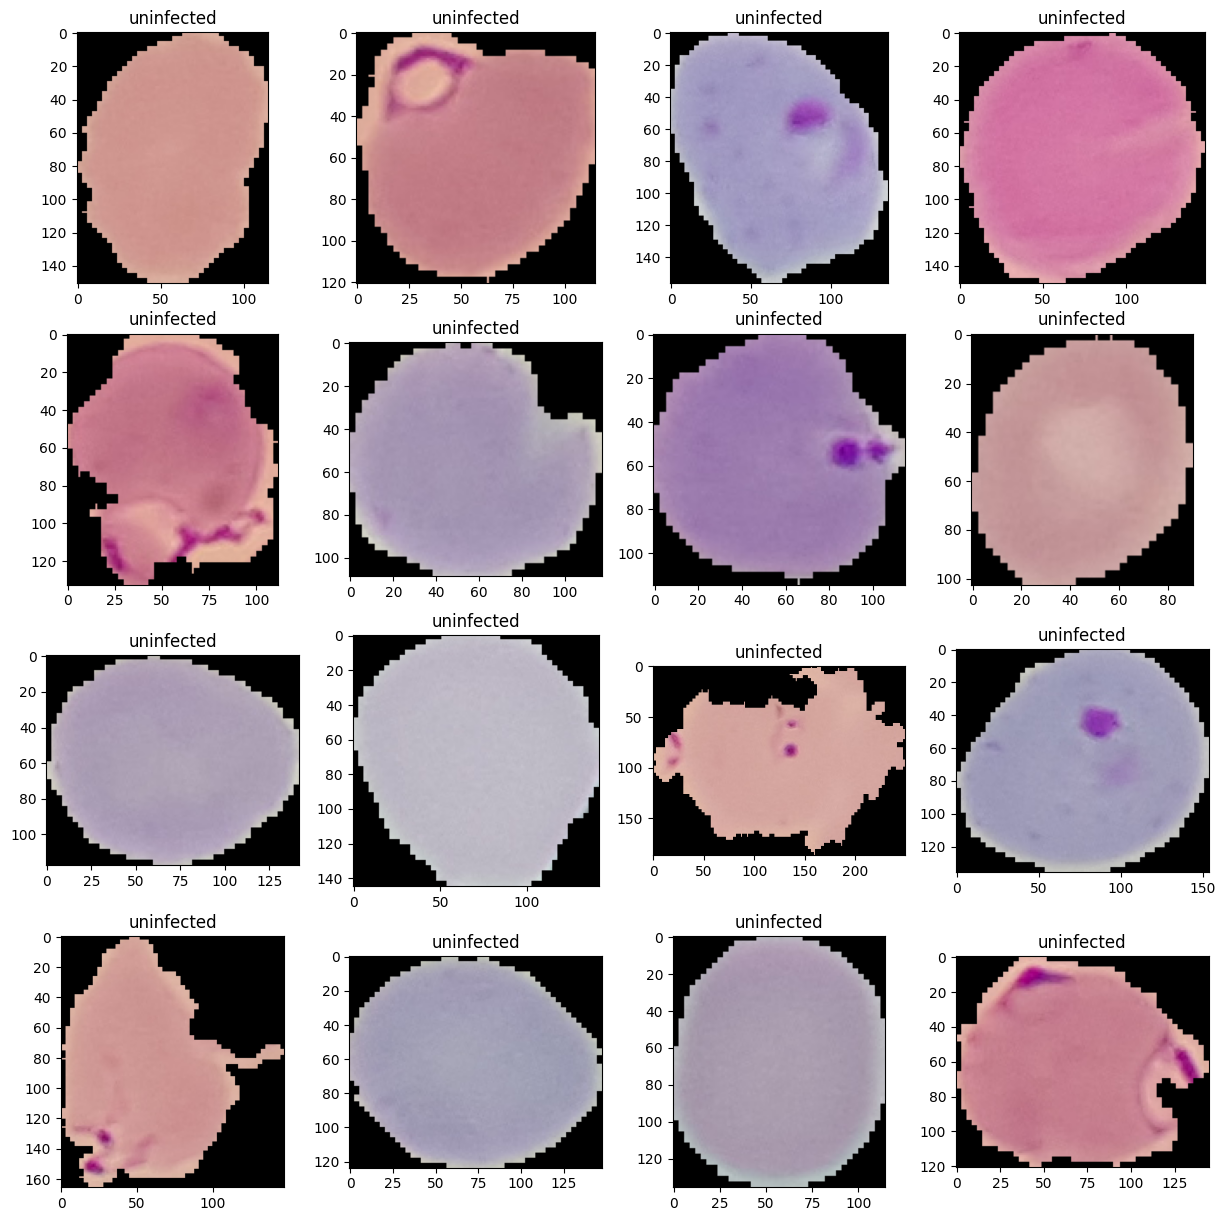

In [6]:
plt.figure(figsize=(15,15))
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image)

  plt.title(dataset_info.features['label'].int2str(1))

In [7]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Processing

In [8]:
IM_SIZE=224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0 , label

In [9]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)

In [10]:
for image,label in train_dataset.take(1):
  print(image)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)


In [11]:
BATCH_SIZE=32
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#test_dataset = test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
model = tf.keras.Sequential([InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

                             Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Flatten(),

                             Dense(100,activation ="relu"),
                             BatchNormalization(),

                             Dense(10,activation ="relu"),
                             BatchNormalization(),

                             Dense(1,activation ="sigmoid"),

                             ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Error definetion

In [14]:
model.compile(optimizer= Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              metrics='accuracy'
              )

In [15]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=100,verbose=1)

Epoch 1/100
689/689 [==============================] - 59s 69ms/step - loss: 0.2867 - accuracy: 0.8909 - val_loss: 4.6912 - val_accuracy: 0.5303
Epoch 2/100
689/689 [==============================] - 54s 78ms/step - loss: 0.5798 - accuracy: 0.6681 - val_loss: 0.7656 - val_accuracy: 0.5554
Epoch 3/100
689/689 [==============================] - 53s 76ms/step - loss: 0.6342 - accuracy: 0.6314 - val_loss: 0.7533 - val_accuracy: 0.5789
Epoch 4/100
689/689 [==============================] - 45s 65ms/step - loss: 0.6134 - accuracy: 0.6569 - val_loss: 78.7121 - val_accuracy: 0.4940
Epoch 5/100
689/689 [==============================] - 47s 68ms/step - loss: 0.5960 - accuracy: 0.6746 - val_loss: 0.7359 - val_accuracy: 0.6015
Epoch 6/100
689/689 [==============================] - 54s 78ms/step - loss: 0.5410 - accuracy: 0.7245 - val_loss: 1.9878 - val_accuracy: 0.5644
Epoch 7/100
689/689 [==============================] - 46s 67ms/step - loss: 0.4513 - accuracy: 0.7851 - val_loss: 0.5295 - val_a

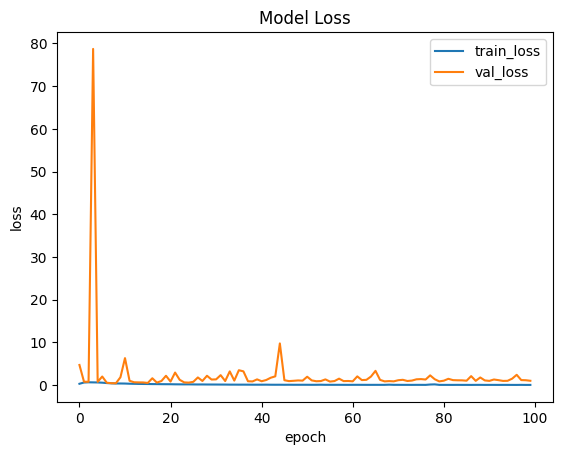

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

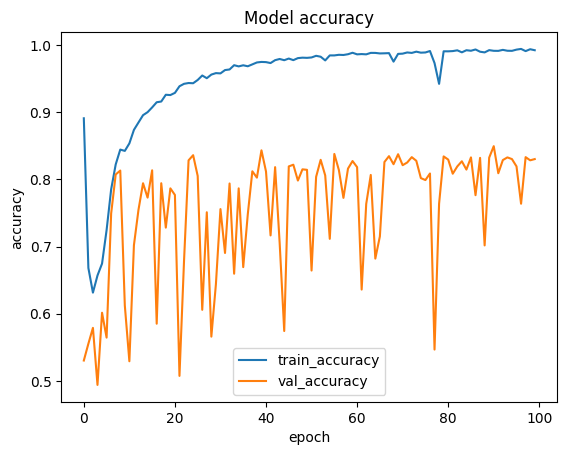

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [29]:
test_dataset = test_dataset.batch(1)

In [30]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [31]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.9143 - accuracy: 0.8353


[0.9142725467681885, 0.8353282809257507]

In [32]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.07671735

In [33]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else :
    return str('U')

In [34]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 13s 13s/step


'U'

1/1 [==============================] - 0s 22ms/step


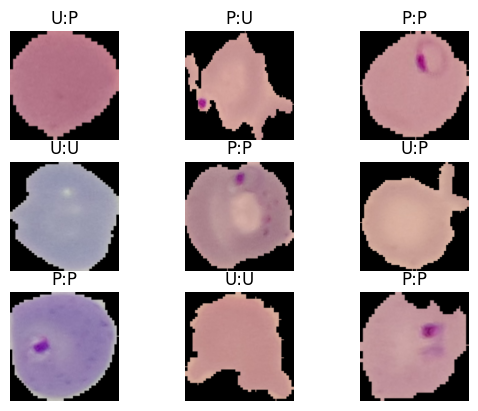

In [35]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+ ":"+ str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')